In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import plotly.graph_objects as go


##### df1 #####

dir = "/home/karner/Documents/github/MagneticParticles/rigid_magnetic/results/MAG2P_order_parameters_per_cluster-2026-1-13-18:15:54.pickle"
#dir = "/home/karner/Documents/github/MagneticParticles/rigid_magnetic/results/MAG2P_order_parameters_per_cluster-CUTOFF_1.6-2026-2-13-11:51:35.pickle"
dg = pd.read_pickle(dir)
df1 = dg.fillna(0)



/tmp/ipykernel_32238/108647977.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  arr_vb = pd.read_csv("/home/karner/Documents/github/MagneticParticles/rigid_magnetic/results/Vb_vs_s.txt", delim_whitespace=True, header=None).values


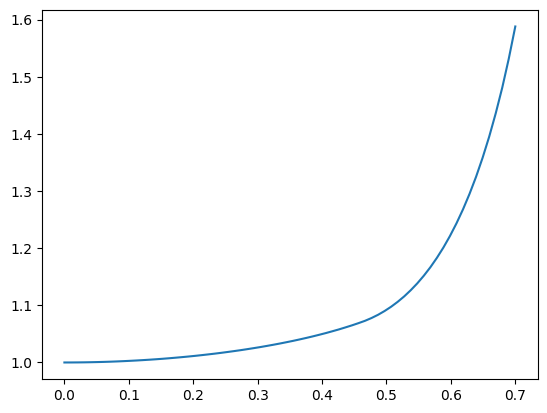

In [2]:
import matplotlib.pyplot as plt
arr_vb = pd.read_csv("/home/karner/Documents/github/MagneticParticles/rigid_magnetic/results/Vb_vs_s.txt", delim_whitespace=True, header=None).values
fig, ax = plt.subplots()
plt.plot(arr_vb[:, 0], arr_vb[:, 1])
plt.show()

def renormalize_lbda_bonding_Volume(lbda, s):
    # interpolate Vb for the given s
    Vb = np.interp(s, arr_vb[:, 0], arr_vb[:, 1])
    # renormalize λ by Vb
    RE_lbda = lbda / Vb 
    return RE_lbda


In [3]:

def U2_chain(s):
    sigma = 1
    sr = 0.5 * s
    theta = np.arctan(2 * sr / sigma)
    d = np.sqrt(1 + np.power(2 * sr, 2))
    U = -4 + (2 / np.power(d, 3)) * (1 - 3 * np.power(np.cos(theta), 2))
    return U


def U2_ap(s):
    sr = 0.5 * s
    U1 = -1 / np.power(1 - 2 * sr, 3)
    U2 = -1
    U3 = -1 / np.power(1 + 2 * sr, 3)
    U = U1 + 2 * U2 + U3
    return U


def renormalize_lbda(lbda, s):
    LBD0 = np.min([U2_chain(0), U2_ap(0)])
    MIN_lbda = np.min([U2_chain(s), U2_ap(s)])
    RE_lbda = lbda * (LBD0 / MIN_lbda)
    return RE_lbda

renormalize_lbda_vec = np.vectorize(renormalize_lbda, otypes=[float])
renormalize_lbda_bonding_Volume_vec = np.vectorize(renormalize_lbda_bonding_Volume, otypes=[float])

df1_re = df1.copy()
df1_re["lambda_re"] = renormalize_lbda_vec(df1_re["lambda"].to_numpy(), df1_re["shift"].to_numpy())

df2_re = df1.copy()
df2_re["lambda_re"] = renormalize_lbda_bonding_Volume_vec(df2_re["lambda"].to_numpy(), df2_re["shift"].to_numpy())




In [4]:
df1_re[df1_re["shift"]==0.05]["lambda_re"].unique().max()

np.float64(100.37464736703303)

In [5]:
def topo_cell_colors(df1, shift_col="shift", lambda_col="lambda"):
    # aggregate like before
    counts = (
        df1.groupby([lambda_col, shift_col, "structure_type"])["cluster_size"]
           .sum()
           .unstack("structure_type", fill_value=0)
    )
    for s in STRUCTS:
        if s not in counts.columns:
            counts[s] = 0
    counts = counts[STRUCTS]

    totals = counts.sum(axis=1)
    pct = counts.div(totals, axis=0).fillna(0.0)

    P = pct.to_numpy()
    top2_idx = np.argsort(-P, axis=1)[:, :2]
    p2vals = np.take_along_axis(P, top2_idx, axis=1)

    s_arr = np.array(STRUCTS, dtype=object)
    s1 = s_arr[top2_idx[:, 0]]
    s2 = s_arr[top2_idx[:, 1]]
    p1 = p2vals[:, 0]
    p2 = p2vals[:, 1]
    mass2 = np.maximum(p1 + p2, 1e-12)
    t = p2 / mass2

    colors = []
    for a, b, ti in zip(s1, s2, t):
        Ca, Cb = BASE[a], BASE[b]
        M = pair_mid_color(a, b)
        colors.append(rgb_str(bent_mix(Ca, Cb, M, float(ti), bend=BEND)))

    out = pd.DataFrame({
        lambda_col: pct.index.get_level_values(lambda_col).to_numpy(),
        shift_col:  pct.index.get_level_values(shift_col).to_numpy(),
        "s1": s1, "s2": s2, "p1": p1, "p2": p2, "top2_mass": mass2,
        "fillcolor": colors,
        "total_cluster_size": totals.to_numpy(),
    })
    return out


def add_renorm_topology_rectangles(
    fig,
    df1_re,                 # must contain: shift, lambda (raw), lambda_plot (renorm)
    row=1, col=1,
    shift_col="shift",
    lambda_raw_col="lambda",
    lambda_plot_col="lambda_re",
    lambda_plot_max=100.0,
):
    # compute per-cell colors/top2 on RAW lambda grid
    cells = topo_cell_colors(df1_re, shift_col=shift_col, lambda_col=lambda_raw_col)

    # attach renormalized lambda value
    key = [shift_col, lambda_raw_col]
    cells = cells.merge(
        df1_re[[shift_col, lambda_raw_col, lambda_plot_col]].drop_duplicates(key),
        on=key,
        how="left"
    )

    # limit y-range
    cells = cells[cells[lambda_plot_col] <= lambda_plot_max].copy()

    # shift edges (x0/x1) via midpoints
    shifts = np.sort(cells[shift_col].unique())
    if len(shifts) < 2:
        dx = 0.05
        x_edges = np.array([shifts[0]-dx, shifts[0]+dx])
    else:
        mids = 0.5 * (shifts[1:] + shifts[:-1])
        x_edges = np.concatenate([[shifts[0] - (mids[0]-shifts[0])], mids, [shifts[-1] + (shifts[-1]-mids[-1])]])

    # map shift -> (x0,x1)
    x0_map = {s: x_edges[i] for i, s in enumerate(shifts)}
    x1_map = {s: x_edges[i+1] for i, s in enumerate(shifts)}

    # we will add shapes in the correct subplot axes
    xa = f"x{(col if col > 1 else '')}"
    ya = f"y{(col if col > 1 else '')}"  # y axis index matches subplot column here (row=1)
    # NOTE: if you ever move this to another row/col, use fig.get_subplot to be exact.

    shapes = []

    # also build an invisible scatter for hover
    hover_x, hover_y, custom = [], [], []

    for s in shifts:
        sub = cells[cells[shift_col] == s].sort_values(lambda_plot_col)
        ys = sub[lambda_plot_col].to_numpy()

        if len(ys) == 0:
            continue

        # y-edges by midpoints within THIS shift (no binning)
        if len(ys) == 1:
            dy = 0.25
            y_edges = np.array([ys[0]-dy, ys[0]+dy])
        else:
            y_mids = 0.5 * (ys[1:] + ys[:-1])
            y_edges = np.concatenate([[ys[0] - (y_mids[0]-ys[0])], y_mids, [ys[-1] + (ys[-1]-y_mids[-1])]])

        for k, r in enumerate(sub.itertuples(index=False)):
            y0, y1 = y_edges[k], y_edges[k+1]
            shapes.append(dict(
                type="rect",
                xref=xa, yref=ya,
                x0=x0_map[s], x1=x1_map[s],
                y0=y0, y1=y1,
                fillcolor=r.fillcolor,
                line=dict(width=0.5, color=r.fillcolor),
                layer="below",
            ))

            # hover point at center
            hover_x.append(s)
            hover_y.append(float(getattr(r, lambda_plot_col)))
            custom.append([r.s1, r.s2, r.p1, r.p2, r.top2_mass, r.total_cluster_size])

    # set shapes
    fig.update_layout(shapes=(fig.layout.shapes + tuple(shapes)))

    # invisible hover layer
    fig.add_trace(
        go.Scatter(
            x=hover_x,
            y=hover_y,
            mode="markers",
            marker=dict(size=6, opacity=0),
            customdata=np.array(custom, dtype=object),
            hovertemplate=(
                "shift=%{x}<br>λ (renorm)=%{y:.3f}<br>"
                "<b>top2</b>: %{customdata[0]} (%{customdata[2]:.1%})  vs  %{customdata[1]} (%{customdata[3]:.1%})<br>"
                "top2 mass=%{customdata[4]:.1%}<br>"
                "total cluster_size=%{customdata[5]:.0f}"
                "<extra></extra>"
            ),
            showlegend=False,
            name="topology (renorm hover)"
        ),
        row=row, col=col
    )



In [6]:
import numpy as np
import pandas as pd
import kaleido
import plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import colorsys, hashlib
import cmasher as cmr

# ============================================================
# Shared settings
# ============================================================
LAMBDA_MAX = 100
TICK_FONT = 16
TITLE_FONT = 18

def cmasher_to_plotly_colorscale(cmap, n=256):
    xs = np.linspace(0, 1, n)
    colors = []
    for x in xs:
        r, g, b, a = cmap(x)
        colors.append([float(x), f"rgba({int(r*255)},{int(g*255)},{int(b*255)},{a:.3f})"])
    return colors


# ============================================================
# 1) Topological (df1) — your exact style, returns heatmap + legend traces
# ============================================================
STRUCTS = ['chain', 'liquid', 'complex_network', 'ring', 'strongly_clustered']
BEND = 0.35

BASE_HEX = {
    "chain":              "#000000",
    "liquid":             "#86878A",
    "complex_network":    "#1CA879",
    "ring":               "#591FDF",
    "strongly_clustered": "#EEBF25",
}

def hex_to_rgb255(h):
    h = h.lstrip("#")[:6]
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)], dtype=float)

BASE = {k: hex_to_rgb255(v) for k, v in BASE_HEX.items()}

def rgb_str(rgb):
    rgb = np.clip(np.round(rgb), 0, 255).astype(int)
    return f"rgb({rgb[0]},{rgb[1]},{rgb[2]})"

def pair_key(a, b):
    return "|".join(sorted([a, b]))

def pair_mid_color(a, b):
    key = pair_key(a, b).encode("utf-8")
    h = (int(hashlib.md5(key).hexdigest()[:8], 16) % 360) / 360.0
    s, v = 0.65, 0.97
    r, g, bb = colorsys.hsv_to_rgb(h, s, v)
    return np.array([r, g, bb]) * 255.0

def bent_mix(Ca, Cb, M, t, bend=BEND):
    straight_mid = 0.5 * (Ca + Cb)
    P1 = (1 - bend) * straight_mid + bend * M
    return (1-t)**2 * Ca + 2*(1-t)*t * P1 + t**2 * Cb

def make_topological_traces(df1, shift_col="shift", lambda_col="lambda"):
    df_filt = df1[df1[lambda_col] <= LAMBDA_MAX].copy()

    counts = (
        df_filt.groupby([lambda_col, shift_col, "structure_type"])["cluster_size"]
              .sum()
              .unstack("structure_type", fill_value=0)
    )
    for s in STRUCTS:
        if s not in counts.columns:
            counts[s] = 0
    counts = counts[STRUCTS]

    totals = counts.sum(axis=1)
    pct = counts.div(totals, axis=0).fillna(0.0)

    P = pct.to_numpy()
    top2_idx = np.argsort(-P, axis=1)[:, :2]
    p2vals = np.take_along_axis(P, top2_idx, axis=1)

    s_arr = np.array(STRUCTS, dtype=object)
    s1 = s_arr[top2_idx[:, 0]]
    s2 = s_arr[top2_idx[:, 1]]
    p1 = p2vals[:, 0]
    p2 = p2vals[:, 1]
    mass2 = np.maximum(p1 + p2, 1e-12)
    t = p2 / mass2

    top2 = pd.DataFrame({
        lambda_col: pct.index.get_level_values(lambda_col),
        shift_col:  pct.index.get_level_values(shift_col),
        "s1": s1, "s2": s2,
        "p1": p1, "p2": p2,
        "top2_mass": mass2,
        "total_cluster_size": totals.to_numpy(),
    }).reset_index(drop=True)

    lam_vals = np.sort(top2[lambda_col].unique())
    shi_vals = np.sort(top2[shift_col].unique())
    H, W = len(lam_vals), len(shi_vals)

    s1_grid = top2.pivot(index=lambda_col, columns=shift_col, values="s1").reindex(index=lam_vals, columns=shi_vals).to_numpy()
    s2_grid = top2.pivot(index=lambda_col, columns=shift_col, values="s2").reindex(index=lam_vals, columns=shi_vals).to_numpy()
    t_grid  = (
        top2.pivot(index=lambda_col, columns=shift_col, values="p2").reindex(index=lam_vals, columns=shi_vals) /
        top2.pivot(index=lambda_col, columns=shift_col, values="top2_mass").reindex(index=lam_vals, columns=shi_vals)
    ).fillna(0.0).to_numpy()

    p1_grid = top2.pivot(index=lambda_col, columns=shift_col, values="p1").reindex(index=lam_vals, columns=shi_vals).to_numpy()
    p2_grid = top2.pivot(index=lambda_col, columns=shift_col, values="p2").reindex(index=lam_vals, columns=shi_vals).to_numpy()
    m2_grid = top2.pivot(index=lambda_col, columns=shift_col, values="top2_mass").reindex(index=lam_vals, columns=shi_vals).to_numpy()
    tot_grid= top2.pivot(index=lambda_col, columns=shift_col, values="total_cluster_size").reindex(index=lam_vals, columns=shi_vals).to_numpy()

    color_grid = np.empty((H, W), dtype=object)
    for i in range(H):
        for j in range(W):
            a = s1_grid[i, j]
            b = s2_grid[i, j]
            if not isinstance(a, str) or not isinstance(b, str):
                color_grid[i, j] = "rgb(255,255,255)"
                continue
            Ca, Cb = BASE[a], BASE[b]
            M = pair_mid_color(a, b)
            rgb = bent_mix(Ca, Cb, M, float(t_grid[i, j]), bend=BEND)
            color_grid[i, j] = rgb_str(rgb)

    # per-cell colorscale trick
    N = H * W
    ids = np.arange(N).reshape(H, W)
    z = ids / (N - 1 if N > 1 else 1)

    colorscale = []
    flat = color_grid.reshape(-1)
    for k in range(N):
        v0 = k / (N - 1 if N > 1 else 1)
        v1 = (k + 1) / (N - 1) if (N > 1 and k < N - 1) else 1.0
        c = flat[k]
        colorscale.append((v0, c))
        colorscale.append((v1, c))

    customdata = np.stack([s1_grid.astype(object), s2_grid.astype(object), p1_grid, p2_grid, m2_grid, tot_grid], axis=-1)

    hovertemplate = (
        "shift=%{x}<br>λ=%{y}<br>"
        "<b>top2</b>: %{customdata[0]} (%{customdata[2]:.1%})  vs  %{customdata[1]} (%{customdata[3]:.1%})<br>"
        "top2 mass=%{customdata[4]:.1%}<br>"
        "total cluster_size=%{customdata[5]:.0f}"
        "<extra></extra>"
    )

    topo_heat = go.Heatmap(
        x=shi_vals,
        y=lam_vals,
        z=z,
        zmin=0, zmax=1,
        colorscale=colorscale,
        showscale=False,   # categorical -> legend instead
        customdata=customdata,
        hovertemplate=hovertemplate,
        name="topology"
    )

    STRUCT_LABELS = {
    "chain": "chain",
    "liquid": "liquid",
    "complex_network": "complex network",
    "ring": "ring",
    "strongly_clustered": "strongly clustered",
}


    legend_traces = []
    for s in STRUCTS:
        legend_traces.append(
            go.Scatter(
                x=[None], y=[None],
                mode="markers",
                marker=dict(symbol="square", size=12, color=BASE_HEX[s]),
                name=STRUCT_LABELS[s],
                hoverinfo="skip",
                showlegend=True,
            )
        )

    return topo_heat, legend_traces


# ============================================================
# COMBINED FIGURE (1x3)
# ============================================================

from plotly.subplots import make_subplots
import plotly.graph_objects as go


def make_topology_triptych_first_renormalized(df1_raw, df1_ren,
                                              width=1650, height=480):
    # build subplots as before
    fig = make_subplots(rows=1, cols=3, shared_xaxes=True, shared_yaxes=False, horizontal_spacing=0.07,
                        subplot_titles=("Connectivity (no renormalization)",
                                    "Connectivity (renormalized with minimum contact energy)",
                                    "Connectivity (renormalized with bonding volume)"))

    # col2/col3 raw heatmaps (your original)
    topo_raw, topo_legend = make_topological_traces(df1, lambda_col="lambda")
    fig.add_trace(topo_raw, row=1, col=2)
    #fig.add_trace(topo_raw, row=1, col=3)

    # legend swatches once
    for tr in topo_legend:
        fig.add_trace(tr, row=1, col=2)

    # col1: draw rectangles + invisible hover points
    add_renorm_topology_rectangles(fig, df1_re, row=1, col=1)
    add_renorm_topology_rectangles(fig, df2_re, row=1, col=3)


    # axes
    fig.update_xaxes(title_text="shift", tickfont=dict(size=TICK_FONT), title_font=dict(size=TITLE_FONT))
    fig.update_yaxes(title_text="λ", row=1, col=1)
    fig.update_yaxes(title_text="λ*", row=1, col=2)
    fig.update_yaxes(title_text="λ'", row=1, col=3)

    fig.update_yaxes(range=[1, 20], row=1, col=1)  # enforce max 20 as you requested
    fig.update_yaxes(range=[1, 20], row=1, col=2)  # enforce max 20 as you requested
    fig.update_yaxes(range=[1, 20], row=1, col=3)  # enforce max 20 as you requested


    fig.update_annotations(font=dict(size=TITLE_FONT))

    fig.update_layout(
        template="plotly_white",
        width=width,
        height=height,
        margin=dict(l=60, r=250, t=40, b=40),
        legend=dict(
            title="Connectivity types",
            yanchor="top", y=1.0,
            xanchor="left", x=1.07,
            font=dict(size=13),
        ),
    )

    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=False, zeroline=False)

    return fig



# ============================================================
# RUN
# ============================================================


fig = make_topology_triptych_first_renormalized(df1, df1_re)
fig.show()
fig.write_image("test.pdf", width=1650, height=480, scale=1)
